In [416]:
import pyulog
import numpy as np
from matplotlib import pyplot as plt
from numpy.polynomial.polynomial import polyfit

In [417]:
path = '/home/sequoyah/Software/PX4-Autopilot/build/px4_sitl_default/rootfs/log/2023-03-13/'
ulog_file = '03_44_56.ulg'

log = pyulog.ULog(path + ulog_file)

# show available datasets held by ulog_file
# LOG = log.data_list
# for dataset in LOG:
#     print(dataset.name)

In [418]:
# Get raw data

# PX4 Normalized thrust [0,1]
actuator_ctrl_dataset = log.get_dataset('actuator_controls_0')
#print(dir(actuator_ctrl_dataset)) # show attributes of object
ctrl_dict = actuator_ctrl_dataset.data # dictionary
ctrl_times_init = ctrl_dict['timestamp']
PX4thrust_raw_init = ctrl_dict['control[3]']
ctrl_times = ctrl_times_init[PX4thrust_raw_init < 1.0]
PX4thrust_raw = PX4thrust_raw_init[PX4thrust_raw_init < 1.0]

# Mass-normalized thrust (units of m/s^2)
accel_dataset = log.get_dataset('vehicle_acceleration')
accel_dict = accel_dataset.data # dictionary
acc_times = accel_dict['timestamp']
acc_raw = np.empty((acc_times.size, 3))
acc_raw[:] = np.nan;
acc_raw[:,0] = accel_dict['xyz[0]'] # units of m/s^2
acc_raw[:,1] = accel_dict['xyz[1]']
acc_raw[:,2] = accel_dict['xyz[2]']

# Attitude data
att_dataset = log.get_dataset('vehicle_attitude_groundtruth')
att_dict = att_dataset.data
att_times = att_dict['timestamp']
att_raw = np.empty((att_times.size, 4))
att_raw[:] = np.nan
att_raw[:,0] = att_dict['q[0]']
att_raw[:,1] = att_dict['q[1]']
att_raw[:,2] = att_dict['q[2]']
att_raw[:,3] = att_dict['q[3]']

# Position data
pos_dataset = log.get_dataset('vehicle_local_position_groundtruth')
pos_dict = pos_dataset.data
z_times = pos_dict['timestamp']
z_raw = pos_dict['z'] # negative height
flight_times = z_times[z_raw < -0.3] # timestamps when quad is off the ground by 30 cm

print(PX4thrust_raw.shape)
print(acc_raw.shape)
print(att_raw.shape)
print(flight_times.shape)

(938,)
(985, 3)
(4919, 4)
(914,)


In [419]:
# Prune data with non-matching timestamps

def times_intersect(t_stamps1, t_stamps2, t_stamps3, t_stamps4):
    i12_stamps  = t_stamps1[np.isin(t_stamps1, t_stamps2)]  # intersection of t_stamps1 and t_stamps2
    i123_stamps = t_stamps3[np.isin(t_stamps3, i12_stamps)]
    i1234_stamps = t_stamps4[np.isin(t_stamps4, i123_stamps)]
    return i1234_stamps

common_times = times_intersect(ctrl_times, acc_times, att_times, flight_times) # timestamps shared by all dicts
idx_keep_thrust = np.isin(ctrl_times, common_times) # thrust indices aligning with common timestamps
idx_keep_acc    = np.isin( acc_times, common_times) # accel indices aligning with common timestamps
idx_keep_att    = np.isin( att_times, common_times) # attitude indices aligning with common timestamps

PX4thrust = PX4thrust_raw[idx_keep_thrust]
acc = acc_raw[idx_keep_acc,:]
att = att_raw[idx_keep_att,:]

print(PX4thrust.shape)
print(acc.shape)
print(att.shape)

(158,)
(158, 3)
(158, 4)


In [420]:
# Functions for rotating a 3-vector by a quaternion

def q_mult(q1, q0):
    # quaternion product q1xq0
    w0, x0, y0, z0 = q0
    w1, x1, y1, z1 = q1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)
def q_inv(q):
    # quaternion inverse
    return np.array([-q[0], q[1], q[2], q[3]])
def pnt2q(pnt):
    # represent a 3-vector as a quaternion
    return np.array([0, pnt[0], pnt[1], pnt[2]])
def q2pnt(q):
    # remove extra zero from rotated pnt
    assert abs(q[0]) < 1e-14, f"q[0] too big, got: {q[0]}" # make sure the removed value is about zero
    return np.array([q[1], q[2], q[3]])
def q_rotate(pnt, q):
    # rotate pnt by q
    result_q = q_mult(q_inv(q), q_mult( pnt2q(pnt),q))
    return q2pnt(result_q)

In [421]:
# Estimate mass-normalized thrust

acc_w = np.empty(3)
g = np.array([0,0,9.81])
mass_norm_thrust = np.empty(common_times.size)
mass_norm_thrust[:] = np.nan

for i in range(common_times.size):
    acc_w = q_rotate(acc[i,:], att[i,:]) # Express imu acceleration in world frame
    acc_w = acc_w - g # Compensate for gravity (stationary imu measures gravity)
    mass_norm_thrust[i] = np.linalg.norm(acc_w + g) # Estimate mass-normalized thrust

[0.00013850414341400538, -0.005408755617324549, 0.11336157680888627, -0.0022807568577082674]


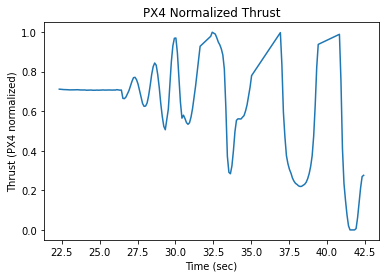

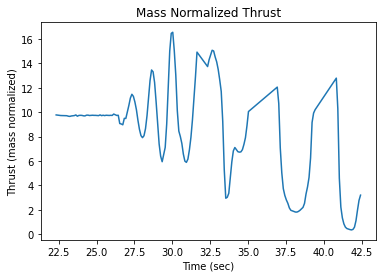

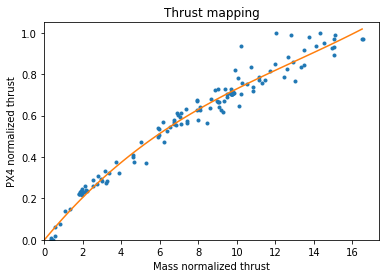

In [422]:
# Create plots

start_sec = 0
end_sec = np.inf
# end_sec = 42
plt_idx = (common_times*1e-6 > start_sec)*(common_times*1e-6 < end_sec) # only plot in time frame

plt.figure(1)
plt.plot(common_times[plt_idx]*1e-6, PX4thrust[plt_idx])
plt.xlabel('Time (sec)')
plt.ylabel('Thrust (PX4 normalized)')
plt.title('PX4 Normalized Thrust')

plt.figure(2)
plt.plot(common_times[plt_idx]*1e-6, mass_norm_thrust[plt_idx])
plt.xlabel('Time (sec)')
plt.ylabel('Thrust (mass normalized)')
plt.title('Mass Normalized Thrust')

plt.figure(3)
plt.plot(mass_norm_thrust[plt_idx], PX4thrust[plt_idx], '.')
plt.xlabel('Mass normalized thrust')
plt.ylabel('PX4 normalized thrust')
plt.title('Thrust mapping')
plt.xlim(0)
plt.ylim(0,1.05)

d, c, b, a = polyfit(mass_norm_thrust[plt_idx],  PX4thrust[plt_idx], 3)
print([a,b,c,d])
# a,b,c,d = [0.00013850414341400538, -0.005408755617324549, 0.11336157680888627, -0.0022807568577082674]
x = np.linspace(0,16.5,100)
plt.plot(x, a*x*x*x + b*x*x + c*x + d)

# Display the plots
plt.show()